## 线性回归和随机梯度下降

---

本次挑战中，你需要使用随机梯度下降方法来完成线性回归问题。

首先，我们导入挑战可能需要到的模块：

In [1]:
import warnings
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')

下面，加载挑战所使用的示例数据集。

In [2]:
data_demo = pd.read_csv(
    'https://labfile.oss.aliyuncs.com/courses/1283/weights_heights.csv')
data_demo.head()

,Index,Height,Weight
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


每个样本数据包含 2 个特征，我们绘制二维散点图。

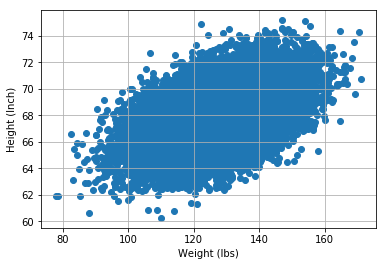

In [3]:
plt.scatter(data_demo['Weight'], data_demo['Height'])
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (Inch)')
plt.grid()

接下来，设定 `Weight` 为 `X`，`Height` 为 `y`。

In [4]:
X, y = data_demo['Weight'].values, data_demo['Height'].values

然后将数据集切分为训练和验证数据，并进行规范化。

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=17)

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape([-1, 1]))
X_valid_scaled = scaler.transform(X_valid.reshape([-1, 1]))

X_train_scaled.shape, X_valid_scaled.shape

((17500, 1), (7500, 1))

我们同样可以将规范化之后的训练数据绘制成散点图。

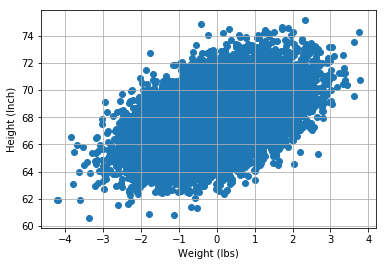

In [7]:
plt.scatter(X_train_scaled, y_train)
plt.xlabel('Weight (lbs)')
plt.ylabel('Height (Inch)')
plt.grid()

接下来，你需要实现一个使用随机梯度下降方法的线性回归类，并使其可以完成训练和测试的过程。

<i class="fa fa-question-circle" aria-hidden="true"> 问题：</i>按下面的要求实现随机梯度下降线性回归类。

- 类名为 `SGDRegressor`，其继承自 `sklearn.base.BaseEstimator`。
- 构造函数接受参数 `eta` 学习率（默认为 $10^{-3}$）和 `n_epochs` 全数据集迭代次数（默认为 3）。
- 构造函数创建 `mse_` 和 `weights_` 列表，以便在梯度下降迭代期间追踪均方误差和权重向量。
- 该类需包含 `fit` 和 `predict` 方法用于训练和预测。
- `fit` 方法可接受矩阵 `X` 和向量 `y`（`numpy.array` 对象）作为参数。该方法可自动在 `X` 左侧追加一列全为 `1` 的值作为截距项系数，权重 `w` 则统一用零初始化。然后进行 `n_epochs` 权重更新迭代，并将每次迭代后的均方误差 MSE 和权重向量记录在预先初始化的空列表中。
- `fit` 方法返回 `SGDRegressor` 类的当前实例，即 `self`。
- `predict` 方法可接受矩阵 `X` 矩阵，同样需支持自动在 `X` 左侧追加一列全为 `1` 的值作为截距项系数，并使用由 `fit` 方法得到的权重向量 `w_` 计算后返回预测向量。

In [8]:
class SGDRegressor(BaseEstimator):

    def __init__(self, eta=1e-3, n_epochs=3):
        self.eta = eta
        self.n_epochs = n_epochs
        self.mse_ = []
        self.weights_ = []

    def fit(self, X, y):
        X = np.hstack([np.ones([X.shape[0], 1]), X])
        w = np.zeros(X.shape[1])
        for it in tqdm(range(self.n_epochs)):
            for i in range(X.shape[0]):

                new_w = w.copy()
                new_w[0] += self.eta * (y[i] - w.dot(X[i, :]))
                for j in range(1, X.shape[1]):
                    new_w[j] += self.eta * (y[i] - w.dot(X[i, :])) * X[i, j]
                w = new_w.copy()

                self.weights_.append(w)
                self.mse_.append(mean_squared_error(y, X.dot(w)))

        self.w_ = self.weights_[np.argmin(self.mse_)]
        return self

    def predict(self, X):
        X = np.hstack([np.ones([X.shape[0], 1]), X])

        return X.dot(self.w_)

接下来，我们实例化 `SGDRegressor` 类，并传入训练数据：

In [9]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train_scaled, y_train)

100%|██████████| 3/3 [00:18<00:00,  6.04s/it]


SGDRegressor(eta=0.001, n_epochs=3)

如果一切正常的话，我们可以经由以下代码输出迭代过程中 MSE 的变化曲线：

Text(0, 0.5, 'MSE')

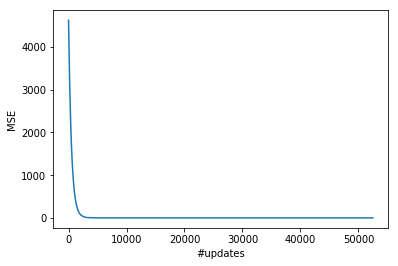

In [10]:
plt.plot(range(len(sgd_reg.mse_)), sgd_reg.mse_)
plt.xlabel('#updates')
plt.ylabel('MSE')

打印出 MSE 的最小值，以及最终的权重系数。

In [11]:
np.min(sgd_reg.mse_), sgd_reg.w_

(2.7151352406643627, array([67.9898497 ,  0.94447605]))

绘制出 $w_0$ 和 $w_1$ 在训练过程中的变化曲线。

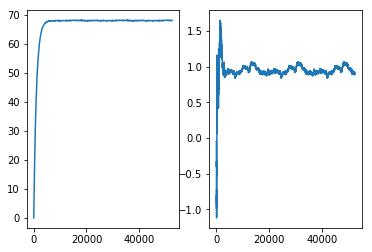

In [12]:
plt.subplot(121)
plt.plot(range(len(sgd_reg.weights_)),
         [w[0] for w in sgd_reg.weights_])
plt.subplot(122)
plt.plot(range(len(sgd_reg.weights_)),
         [w[1] for w in sgd_reg.weights_])

最后，使用 `(X_valid_scaled, y_valid)` 作出预测，并计算验证集上的 MSE 值。

In [13]:
sgd_holdout_mse = mean_squared_error(y_valid,
                                     sgd_reg.predict(X_valid_scaled))
sgd_holdout_mse

2.6708681207033784

最后，我们通过一个单元测试来保证 `SGDRegressor` 已经正常工作。

这里使用 `sklearn.linear_model` 提供的 `LinearRegression` 来计算普通最小二乘法得到在验证集上的 MSE 值。

In [14]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(X_train_scaled, y_train)
print(lm.coef_, lm.intercept_)
linreg_holdout_mse = mean_squared_error(y_valid,
                                        lm.predict(X_valid_scaled))
linreg_holdout_mse

[0.94537278] 67.98930834742858


2.670830767667635

如果 `SGDRegressor` 得到的结果和 `SGDRegressor` 得到的结果在 $10^{-4}$ 范围之内，我们认为测试通过。

In [15]:
try:
    assert (sgd_holdout_mse - linreg_holdout_mse) < 1e-4
    print('Correct!')
except AssertionError:
    print("Something's not good.\n Linreg's holdout MSE: {}"
          "\n SGD's holdout MSE: {}".format(linreg_holdout_mse,
                                            sgd_holdout_mse))

Correct!


---

<div style="background-color: #e6e6e6; margin-bottom: 10px; padding: 1%; border: 1px solid #ccc; border-radius: 6px;text-align: center;"><a href="https://nbviewer.jupyter.org/github/shiyanlou/mlcourse-answers/tree/master/" title="挑战参考答案"><i class="fa fa-file-code-o" aria-hidden="true"> 查看挑战参考答案</i></a></div>